# UNet Time Evolution Operator for 2D Cylinder Flow

This notebook implements a UNet as a neural time integrator for 2D cylinder flow using the CFDBench dataset.

**Learning Objective**: Learn the discrete Navier-Stokes flow map:
$$u^{t+\Delta t}(x) = G_\theta(u^t(x), BC, \nu, \rho, geometry)$$

The model is trained as a one-step predictor and advanced autoregressively.

**Advantage over FNO**: UNet is faster on Mac since it doesn't require FFT operations.

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Tuple, List, Dict
import sys

# Add parent directory to path to import data loader
sys.path.append(str(Path.cwd().parent))
from data_handle.data import get_cylinder_auto_datasets

# Set device - UNet works well on MPS (no FFT needed!)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using device: Apple Metal Performance Shaders (MPS)")
    print("UNet works natively on MPS - no FFT operations needed!")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device: CUDA")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simple train/test split function
def train_test_split(*arrays, test_size=0.3, random_state=None, shuffle=True):
    """Simple train/test split without sklearn dependency"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    result = []
    for array in arrays:
        if isinstance(array, (list, tuple)):
            train_data = [array[i] for i in train_indices]
            test_data = [array[i] for i in test_indices]
        else:
            train_data = array[train_indices]
            test_data = array[test_indices]
        result.extend([train_data, test_data])
    
    return tuple(result)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Searching in subset: bc
Data directory: /Users/thaddeusli/Desktop/PH188CFD
Loading partial data: Using 1 out of 50 total cases (1.00%)
==== Number of cases in different splits (Subset) ====
train: 1, dev: 0, test: 0
  [Loader]: Processing data for split 'train' from 1 case(s).
    ⚠ case0043: Truncated from 1000 to 620 timesteps
    ✓ case0043: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min':

## 1. Data Loading with JSON Metadata


In [5]:
# Load data from BC subset (boundary conditions)
DATA_DIR = Path("../../../")
bc_train_data, bc_dev_data, bc_test_data = get_cylinder_auto_datasets(
    data_dir=DATA_DIR,
    subset_name="bc",
    norm_props=True,
    norm_bc=True,
    case_fraction=1.0,  # Use all cases
    load_splits=["train", "dev", "test"]
)

# Combine train and dev for 70/30 split
all_u_data = []
all_v_data = []
all_params = []

if bc_train_data is not None:
    all_u_data.extend(bc_train_data.u_data)
    all_v_data.extend(bc_train_data.v_data)
    all_params.extend(bc_train_data.case_params)

if bc_dev_data is not None:
    all_u_data.extend(bc_dev_data.u_data)
    all_v_data.extend(bc_dev_data.v_data)
    all_params.extend(bc_dev_data.case_params)

print(f"Total cases loaded: {len(all_u_data)}")
print(f"Data shape (first case): u={all_u_data[0].shape}, v={all_v_data[0].shape}")
print(f"Parameters keys: {list(all_params[0].keys())}")



Searching in subset: bc
Data directory: /Users/thaddeusli/Desktop/PH188CFD
==== Number of cases in different splits (Subset) ====
train: 40, dev: 5, test: 5
  [Loader]: Processing data for split 'train' from 40 case(s).
    ⚠ case0043: Truncated from 1000 to 620 timesteps
    ✓ case0043: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 4.3999999999999995, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0001: Truncated from 1000 to 620 timesteps
    ✓ case0001: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 0.2, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 'y_min': -0.06, 'y_max': 0.06}
    ⚠ case0028: Truncated from 1000 to 620 timesteps
    ✓ case0028: u.npy shape (620, 64, 64), v.npy shape (620, 64, 64), params: {'vel_in': 2.9000000000000004, 'density': 10, 'viscosity': 0.001, 'radius': 0.01, 'x_min': -0.06, 'x_max': 0.16, 

## 2. Geometry Mask Creation


Mask shape: (64, 64)
Mask values: min=0.0, max=1.0, mean=0.996826171875


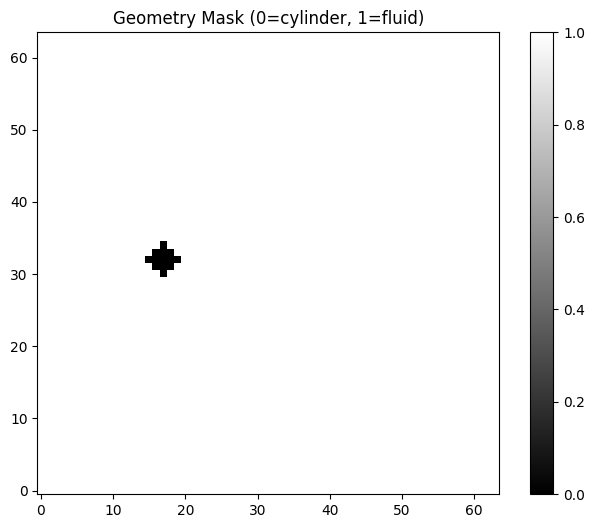

In [6]:
def create_geometry_mask(params: Dict) -> np.ndarray:
    """
    Create binary mask for geometry (1 = fluid, 0 = cylinder)
    """
    H, W = 64, 64  # Spatial dimensions
    mask = np.ones((H, W), dtype=np.float32)
    
    # Extract geometry parameters
    radius = params['radius']
    x_min = params['x_min']
    x_max = params['x_max']
    y_min = params['y_min']
    y_max = params['y_max']
    
    # Calculate cylinder center
    domain_width = x_max - x_min
    domain_height = y_max - y_min
    
    center_x_rel = 0.0 - x_min
    center_y_rel = (y_max + y_min) / 2 - y_min
    
    # Convert to grid coordinates
    center_x_grid = int((center_x_rel / domain_width) * W)
    center_y_grid = int((center_y_rel / domain_height) * H)
    radius_grid = int((radius / domain_width) * W)
    
    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:H, :W]
    
    # Distance from center
    dist_from_center = np.sqrt((x_coords - center_x_grid)**2 + (y_coords - center_y_grid)**2)
    
    # Set mask to 0 inside cylinder
    mask[dist_from_center <= radius_grid] = 0.0
    
    return mask

# Test mask generation
test_mask = create_geometry_mask(all_params[0])
print(f"Mask shape: {test_mask.shape}")
print(f"Mask values: min={test_mask.min()}, max={test_mask.max()}, mean={test_mask.mean()}")
plt.figure(figsize=(8, 6))
plt.imshow(test_mask, cmap='gray', origin='lower')
plt.title('Geometry Mask (0=cylinder, 1=fluid)')
plt.colorbar()
plt.show()


## 3. UNet Architecture Implementation


In [7]:
from typing import List, Optional, Dict
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """Double convolution block with replicate padding and bias"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if mid_channels is None:
            mid_channels = out_channels
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, 
                kernel_size=3, padding=1, 
                bias=True, padding_mode="replicate"
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_channels, out_channels,
                kernel_size=3, padding=1,
                bias=True, padding_mode="replicate"
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle size mismatches with explicit padding (more precise than resize)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """
    Improved UNet for 2D Navier-Stokes time evolution
    
    Features:
    - Residual connection (preds += residual)
    - Output masking (preds = preds * mask)
    - Optional hidden-layer parameter injection
    - Replicate padding for better boundary handling
    - Bilinear upsampling option
    
    Input format options:
    1. Legacy: x [B, H, W, 11] with all channels baked in
    2. New: inputs [B, 2, H, W] (velocities only), case_params [B, n_params], mask [B, H, W]
    """
    def __init__(
        self, 
        in_channels: int = 11, 
        out_channels: int = 2, 
        features: List[int] = [64, 128, 256, 512],
        n_case_params: int = 9,  # u_B, ρ, μ, d, x_min, x_max, y_min, y_max, (mask handled separately)
        insert_case_params_at: str = "hidden",  # "input" or "hidden"
        bilinear: bool = False,
        use_residual: bool = True,
        use_output_mask: bool = True
    ):
        super(UNet, self).__init__()
        assert insert_case_params_at in ["input", "hidden"]
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_case_params = n_case_params
        self.insert_case_params_at = insert_case_params_at
        self.bilinear = bilinear
        self.use_residual = use_residual
        self.use_output_mask = use_output_mask
        
        # Case parameter injection at hidden layer
        if insert_case_params_at == "hidden":
            self.case_params_fc = nn.Linear(n_case_params, features[-1] * 2)
        
        # Input convolution: handle both legacy (11 channels) and new (2 channels + mask) formats
        # If using new format, mask is added separately, so in_conv gets 2+1=3 channels
        # If using legacy format, in_conv gets 11 channels (including mask)
        if insert_case_params_at == "input":
            # New format: inputs (2) + mask (1) + case_params (n_case_params)
            self.in_conv = DoubleConv(in_channels + 1 + n_case_params, features[0])
        else:
            # Legacy format: all channels baked in, or new format without params at input
            self.in_conv = DoubleConv(in_channels + 1, features[0])  # +1 for mask
        
        # Down path
        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        factor = 2 if bilinear else 1
        self.down4 = Down(features[3], features[3] * 2 // factor)
        
        # Up path
        self.up1 = Up(features[3] * 2, features[3] // factor, bilinear)
        self.up2 = Up(features[3], features[2] // factor, bilinear)
        self.up3 = Up(features[2], features[1] // factor, bilinear)
        self.up4 = Up(features[1], features[0], bilinear)
        
        self.out_conv = OutConv(features[0], out_channels)
    
    def forward(
        self, 
        x: torch.Tensor,
        case_params: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None
    ):
        """
        Forward pass with flexible input format
        
        Args:
            x: Input tensor
                - Legacy format: [B, H, W, 11] or [B, 11, H, W] (all channels baked in)
                - New format: [B, 2, H, W] or [B, H, W, 2] (velocities only)
            case_params: Optional [B, n_case_params] tensor with case parameters
            mask: Optional [B, H, W] or [B, 1, H, W] tensor (1=fluid, 0=cylinder)
        
        Returns:
            [B, H, W, out_channels] predictions
        """
        # Handle input format
        if len(x.shape) == 4:
            if x.shape[-1] == 11 or x.shape[-1] == 2:  # Last dim is channels
                x = x.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        
        batch_size, n_chan, height, width = x.shape
        
        # Extract residual (velocity channels only)
        if self.use_residual:
            residual = x[:, :self.out_channels]  # [B, 2, H, W]
        else:
            residual = None
        
        # Handle mask
        if mask is None:
            mask = torch.ones((batch_size, height, width), device=x.device, dtype=x.dtype)
        else:
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)  # [B, 1, H, W]
            elif mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W] -> broadcast
        
        # Add mask to input
        mask_input = mask if mask.dim() == 4 else mask.unsqueeze(1)
        x = torch.cat([x, mask_input], dim=1)  # [B, C+1, H, W]
        
        # Add case_params to input if specified
        if self.insert_case_params_at == "input" and case_params is not None:
            case_params = case_params.unsqueeze(2).unsqueeze(3)  # [B, n_params, 1, 1]
            case_params = case_params.expand(-1, -1, height, width)  # [B, n_params, H, W]
            x = torch.cat([x, case_params], dim=1)  # [B, C+1+n_params, H, W]
        
        # Down path
        x1 = self.in_conv(x)  # [B, features[0], H, W]
        x2 = self.down1(x1)   # [B, features[1], H/2, W/2]
        x3 = self.down2(x2)   # [B, features[2], H/4, W/4]
        x4 = self.down3(x3)   # [B, features[3], H/8, W/8]
        x5 = self.down4(x4)   # [B, features[3]*2, H/16, W/16]
        
        # Inject case_params at hidden layer
        if self.insert_case_params_at == "hidden" and case_params is not None:
            conds = self.case_params_fc(case_params)  # [B, features[3]*2]
            conds = conds.unsqueeze(2).unsqueeze(3)   # [B, features[3]*2, 1, 1]
            x5 = x5 + conds  # Add to bottleneck
        
        # Up path
        x = self.up1(x5, x4)  # [B, features[3], H/8, W/8]
        x = self.up2(x, x3)   # [B, features[2], H/4, W/4]
        x = self.up3(x, x2)   # [B, features[1], H/2, W/2]
        x = self.up4(x, x1)   # [B, features[0], H, W]
        
        # Output
        preds = self.out_conv(x)  # [B, out_channels, H, W]
        
        # Residual connection
        if self.use_residual and residual is not None:
            preds = preds + residual
        
        # Output masking
        if self.use_output_mask:
            mask_output = mask.squeeze(1) if mask.dim() == 4 else mask  # [B, H, W]
            if mask_output.dim() == 2:
                mask_output = mask_output.unsqueeze(0)  # [1, H, W]
            preds = preds * mask_output.unsqueeze(1)  # [B, 1, H, W] -> [B, out_channels, H, W]
        
        # Convert to [B, H, W, out_channels]
        preds = preds.permute(0, 2, 3, 1)
        
        return preds


# Test UNet architecture with legacy format (backward compatible)
print("Testing UNet with legacy format (11 channels baked in)...")
test_model_legacy = UNet(
    in_channels=11, 
    out_channels=2, 
    features=[64, 128, 256, 512],
    insert_case_params_at="hidden",
    use_residual=True,
    use_output_mask=True
).to(device)
test_input_legacy = torch.randn(2, 64, 64, 11).to(device)
test_output_legacy = test_model_legacy(test_input_legacy)
print(f"Legacy input shape: {test_input_legacy.shape}")
print(f"Legacy output shape: {test_output_legacy.shape}")

# Test UNet architecture with new format (separate inputs)
print("\nTesting UNet with new format (separate velocities, params, mask)...")
test_model_new = UNet(
    in_channels=2,  # Only velocities
    out_channels=2,
    features=[64, 128, 256, 512],
    n_case_params=8,  # u_B, ρ, μ, d, x_min, x_max, y_min, y_max
    insert_case_params_at="hidden",
    use_residual=True,
    use_output_mask=True
).to(device)
test_input_new = torch.randn(2, 64, 64, 2).to(device)  # Only velocities
test_case_params = torch.randn(2, 8).to(device)  # Case parameters
test_mask = torch.ones(2, 64, 64).to(device)  # Mask
test_output_new = test_model_new(test_input_new, case_params=test_case_params, mask=test_mask)
print(f"New input shape: {test_input_new.shape}")
print(f"Case params shape: {test_case_params.shape}")
print(f"Mask shape: {test_mask.shape}")
print(f"New output shape: {test_output_new.shape}")

print(f"\nModel parameters: {sum(p.numel() for p in test_model_new.parameters()):,}")
print(f"Model device: {next(test_model_new.parameters()).device}")


Testing UNet with legacy format (11 channels baked in)...
Legacy input shape: torch.Size([2, 64, 64, 11])
Legacy output shape: torch.Size([2, 64, 64, 2])

Testing UNet with new format (separate velocities, params, mask)...
New input shape: torch.Size([2, 64, 64, 2])
Case params shape: torch.Size([2, 8])
Mask shape: torch.Size([2, 64, 64])
New output shape: torch.Size([2, 64, 64, 2])

Model parameters: 31,052,802
Model device: mps:0


## 4. Data Preprocessing


In [8]:
def prepare_input_channels(u_t: np.ndarray, v_t: np.ndarray, params: Dict, mask: np.ndarray) -> np.ndarray:
    """
    Create input tensor with 11 channels:
    [u_x^t, u_y^t, u_B, ρ, μ, d, x1, x2, y1, y2, mask]
    """
    H, W = u_t.shape[-2], u_t.shape[-1]
    
    # Broadcast scalar parameters to spatial dimensions
    u_B = np.full((H, W), params['vel_in'], dtype=np.float32)
    rho = np.full((H, W), params['density'], dtype=np.float32)
    mu = np.full((H, W), params['viscosity'], dtype=np.float32)
    d = np.full((H, W), params['radius'] * 2, dtype=np.float32)  # diameter
    x1 = np.full((H, W), params['x_min'], dtype=np.float32)
    x2 = np.full((H, W), params['x_max'], dtype=np.float32)
    y1 = np.full((H, W), params['y_min'], dtype=np.float32)
    y2 = np.full((H, W), params['y_max'], dtype=np.float32)
    
    # Stack channels: [u_x, u_y, u_B, ρ, μ, d, x1, x2, y1, y2, mask]
    input_channels = np.stack([
        u_t, v_t, u_B, rho, mu, d, x1, x2, y1, y2, mask
    ], axis=-1)  # Shape: (H, W, 11)
    
    return input_channels


from torch.utils.data import Dataset

class CylinderFlowDataset(Dataset):
    """
    Lazy-loading dataset that generates samples on-the-fly
    """
    def __init__(self, u_data_list: List[np.ndarray], v_data_list: List[np.ndarray],
                 params_list: List[Dict], masks_list: List[np.ndarray], 
                 rollout_steps: int = 3,
                 timestep_stride: int = 1,
                 max_samples_per_case: int = None):
        """
        Args:
            timestep_stride: Sample every Nth timestep (1 = all timesteps, 2 = every other, etc.)
            max_samples_per_case: Maximum number of samples per case (None = all)
        """
        self.u_data_list = u_data_list
        self.v_data_list = v_data_list
        self.params_list = params_list
        self.masks_list = masks_list
        self.rollout_steps = rollout_steps
        self.timestep_stride = timestep_stride
        self.max_samples_per_case = max_samples_per_case
        
        # Pre-compute indices with sampling
        self.indices = []
        for case_idx, (u_data, v_data) in enumerate(zip(u_data_list, v_data_list)):
            T = u_data.shape[0]
            # Sample timesteps with stride
            timesteps = list(range(0, T - rollout_steps, timestep_stride))
            # Limit samples per case if specified
            if max_samples_per_case is not None:
                timesteps = timesteps[:max_samples_per_case]
            
            for t in timesteps:
                self.indices.append((case_idx, t))
        
        print(f"Dataset created with {len(self.indices)} samples from {len(u_data_list)} cases")
        if timestep_stride > 1:
            print(f"  (Using timestep_stride={timestep_stride}, sampling every {timestep_stride} timesteps)")
        if max_samples_per_case is not None:
            print(f"  (Limited to {max_samples_per_case} samples per case)")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        case_idx, t = self.indices[idx]
        
        u_data = self.u_data_list[case_idx]
        v_data = self.v_data_list[case_idx]
        params = self.params_list[case_idx]
        mask = self.masks_list[case_idx]
        
        # Current state
        u_t = u_data[t]
        v_t = v_data[t]
        
        # Prepare input (legacy format for backward compatibility)
        input_channels = prepare_input_channels(u_t, v_t, params, mask)
        
        # Extract separate components for new format
        # Velocities only: [B, H, W, 2]
        velocities = np.stack([u_t, v_t], axis=-1)
        
        # Case parameters: [8] - u_B, ρ, μ, d, x_min, x_max, y_min, y_max
        case_params_array = np.array([
            params['vel_in'],
            params['density'],
            params['viscosity'],
            params['radius'] * 2,  # diameter
            params['x_min'],
            params['x_max'],
            params['y_min'],
            params['y_max']
        ], dtype=np.float32)
        
        # Target: future states (K steps ahead)
        target_u = u_data[t+1:t+self.rollout_steps+1]
        target_v = v_data[t+1:t+self.rollout_steps+1]
        target = np.stack([target_u, target_v], axis=-1)  # Shape: (K, H, W, 2)
        
        # Convert to tensors
        input_tensor = torch.FloatTensor(input_channels)  # Legacy format [H, W, 11]
        velocities_tensor = torch.FloatTensor(velocities)  # New format [H, W, 2]
        case_params_tensor = torch.FloatTensor(case_params_array)  # [8]
        mask_tensor = torch.FloatTensor(mask)  # [H, W]
        target_tensor = torch.FloatTensor(target)  # [K, H, W, 2]
        
        # Return both formats: legacy for backward compatibility, new for improved model
        return {
            'legacy': (input_tensor, target_tensor),
            'new': (velocities_tensor, case_params_tensor, mask_tensor, target_tensor)
        }


# Create masks for all cases
masks_list = [create_geometry_mask(params) for params in all_params]

# Create dataset with reduced data for faster training
print("Creating dataset with reduced samples for faster training...")
full_dataset = CylinderFlowDataset(
    all_u_data, all_v_data, all_params, masks_list, 
    rollout_steps=10,  # Increased to 10 steps
    timestep_stride=1,  # Use ALL timesteps (no stride)
    max_samples_per_case=200  # Limit to 200 samples per case to reduce training data
)
print(f"✓ Dataset created: {len(full_dataset)} samples")
print(f"Note: Using reduced dataset (200 samples per case) with 10-step rollout")

# Get a sample
sample_data = full_dataset[0]
legacy_input, legacy_target = sample_data['legacy']
velocities, case_params, mask, target = sample_data['new']

print("Legacy format:")
print(f"  Input shape: {legacy_input.shape}")
print(f"  Target shape: {legacy_target.shape}")

print("\nNew format:")
print(f"  Velocities shape: {velocities.shape}")
print(f"  Case params shape: {case_params.shape}")
print(f"  Mask shape: {mask.shape}")
print(f"  Target shape: {target.shape}")


Creating dataset with reduced samples for faster training...
Dataset created with 9000 samples from 45 cases
  (Limited to 200 samples per case)
✓ Dataset created: 9000 samples
Note: Using reduced dataset (200 samples per case) with 10-step rollout
Legacy format:
  Input shape: torch.Size([64, 64, 11])
  Target shape: torch.Size([10, 64, 64, 2])

New format:
  Velocities shape: torch.Size([64, 64, 2])
  Case params shape: torch.Size([8])
  Mask shape: torch.Size([64, 64])
  Target shape: torch.Size([10, 64, 64, 2])


## 5. Train/Test Split (70% Training, 30% Evaluation)


In [9]:
# 70/30 split using indices
from torch.utils.data import Subset

n_samples = len(full_dataset)
n_train = int(n_samples * 0.7)
indices = np.arange(n_samples)
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:n_train]
eval_indices = indices[n_train:]

train_dataset = Subset(full_dataset, train_indices)
eval_dataset = Subset(full_dataset, eval_indices)

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")
print("Note: Data is loaded on-the-fly in batches")


Training samples: 6300
Evaluation samples: 2700
Note: Data is loaded on-the-fly in batches


## 6. Training Code Block


Training setup: batch_size=16, n_epochs=50
Model features: residual=True, output_mask=True
Parameter injection: hidden
REDUCED DATA MODE - Using 200 samples per case with 10-step rollout
Checkpoint directory: checkpoints/
Batch size: 16
Batches per epoch: 394
Model parameters: 31,052,802
Starting training...
Total epochs: 50, Batches per epoch: 394
------------------------------------------------------------
Epoch [1/50], Batch [20/394], Loss: 0.484059, Time: 1.87s
Epoch [1/50], Batch [40/394], Loss: 0.468302, Time: 1.91s
Epoch [1/50], Batch [60/394], Loss: 0.745614, Time: 1.60s
Epoch [1/50], Batch [80/394], Loss: 0.264962, Time: 1.52s
Epoch [1/50], Batch [100/394], Loss: 0.647678, Time: 1.52s
Epoch [1/50], Batch [120/394], Loss: 0.266311, Time: 1.54s
Epoch [1/50], Batch [140/394], Loss: 0.120983, Time: 1.50s
Epoch [1/50], Batch [160/394], Loss: 0.860618, Time: 1.48s
Epoch [1/50], Batch [180/394], Loss: 0.112825, Time: 1.47s
Epoch [1/50], Batch [200/394], Loss: 0.639123, Time: 1.47s
Ep

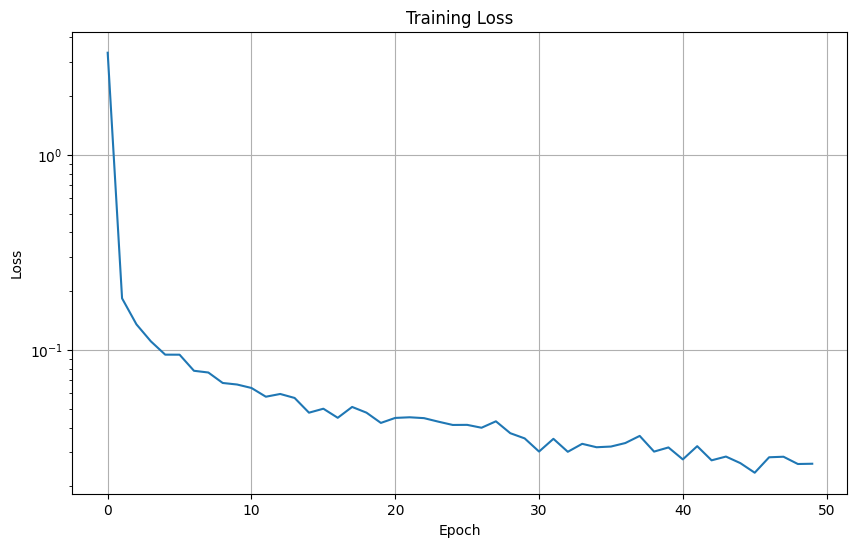

In [10]:
# Initialize improved model with new features
model = UNet(
    in_channels=2,  # Only velocities (parameters handled separately)
    out_channels=2,
    features=[64, 128, 256, 512],
    n_case_params=8,  # u_B, ρ, μ, d, x_min, x_max, y_min, y_max
    insert_case_params_at="hidden",  # Inject at bottleneck for better conditioning
    bilinear=False,  # Use ConvTranspose2d (can set to True for smoother upsampling)
    use_residual=True,  # Enable residual connection
    use_output_mask=True  # Apply mask at output
).to(device)

# Moderate learning rate - balance between learning speed and stability
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Setup model checkpointing
from pathlib import Path
from datetime import datetime
import json

class ModelCheckpointer:
    """Model checkpointing system"""
    def __init__(self, model, optimizer, scheduler, save_dir="checkpoints"):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.best_loss = float('inf')
    
    def save_checkpoint(self, epoch, train_loss, eval_loss=None, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_loss': train_loss,
            'eval_loss': eval_loss,
            'is_best': is_best,
            'timestamp': datetime.now().isoformat(),
        }
        
        # Save latest
        torch.save(checkpoint, self.save_dir / "latest_model.pth")
        
        # Save best
        if is_best and eval_loss is not None:
            torch.save(checkpoint, self.save_dir / "best_model.pth")
            self.best_loss = eval_loss
            print(f"  ✓ Saved BEST model (train_loss: {train_loss:.6f})")
        
        # Save periodic checkpoint every 5 epochs
        if epoch % 5 == 0:
            torch.save(checkpoint, self.save_dir / f"checkpoint_epoch_{epoch:04d}.pth")
            print(f"  ✓ Saved checkpoint: checkpoint_epoch_{epoch:04d}.pth")

# Initialize checkpointer
checkpointer = ModelCheckpointer(model, optimizer, scheduler, save_dir="checkpoints")

# Training parameters - REDUCED DATA WITH 10-STEP ROLLOUT
batch_size = 16
n_epochs = 50  # Full training epochs
rollout_steps = 10  # Increased to 10 steps

print(f"Training setup: batch_size={batch_size}, n_epochs={n_epochs}")
print(f"Model features: residual={model.use_residual}, output_mask={model.use_output_mask}")
print(f"Parameter injection: {model.insert_case_params_at}")
print(f"REDUCED DATA MODE - Using 200 samples per case with 10-step rollout")
print(f"Checkpoint directory: checkpoints/")

# Create data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type != 'cpu' else False
)
eval_loader = DataLoader(
    eval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if device.type != 'cpu' else False
)

print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training loop
train_losses = []
import time

print("Starting training...")
print(f"Total epochs: {n_epochs}, Batches per epoch: {len(train_loader)}")
print("-" * 60)

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start_time = time.time()
    
    for batch_idx, batch_data in enumerate(train_loader):
        batch_start_time = time.time()
        
        # Extract new format data
        batch_velocities, batch_case_params, batch_masks, batch_targets = batch_data['new']
        
        # Move to device
        batch_velocities = batch_velocities.to(device, non_blocking=True)  # [B, H, W, 2]
        batch_case_params = batch_case_params.to(device, non_blocking=True)  # [B, 8]
        batch_masks = batch_masks.to(device, non_blocking=True)  # [B, H, W]
        batch_targets = batch_targets.to(device, non_blocking=True)  # [B, K, H, W, 2]
        
        optimizer.zero_grad()
        
        # Autoregressive rollout loss
        # Clone to avoid in-place modification (which breaks gradients)
        current_velocities = batch_velocities.clone()  # [B, H, W, 2]
        total_loss = 0.0
        
        # Predict K steps ahead autoregressively
        for k in range(rollout_steps):
            # Predict next step using improved model interface
            pred_next = model(
                current_velocities, 
                case_params=batch_case_params, 
                mask=batch_masks
            )  # [B, H, W, 2]
            
            # Get target for this step
            target_k = batch_targets[:, k, :, :, :]  # [B, H, W, 2]
            
            # Compute loss (L2 velocity error with energy weighting)
            velocity_error = torch.mean((pred_next - target_k) ** 2)
            
            # Energy-weighted loss
            u_pred, v_pred = pred_next[:, :, :, 0], pred_next[:, :, :, 1]
            u_target, v_target = target_k[:, :, :, 0], target_k[:, :, :, 1]
            kinetic_energy_pred = 0.5 * (u_pred**2 + v_pred**2)
            kinetic_energy_target = 0.5 * (u_target**2 + v_target**2)
            energy_error = torch.mean((kinetic_energy_pred - kinetic_energy_target) ** 2)
            
            # Combined loss
            step_loss = velocity_error + 0.1 * energy_error
            total_loss += step_loss
            
            # Update current velocities for next autoregressive step
            # (case_params and mask remain constant across rollout)
            current_velocities = pred_next.clone()  # [B, H, W, 2]
        
        # Average loss over rollout steps
        loss = total_loss / rollout_steps
        
        # Backward pass
        loss.backward()
        # Gradient clipping to prevent explosions (moderate clipping)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Check for NaN/Inf to detect instability early (only stop on truly catastrophic losses)
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 1000:
            print(f"\n⚠️ WARNING: Unstable loss detected at epoch {epoch+1}, batch {batch_idx+1}")
            print(f"   Loss value: {loss.item()}")
            print("   Stopping training to prevent further divergence.")
            break
        
        epoch_loss += loss.item()
        
        # Print progress every 20 batches
        if (batch_idx + 1) % 20 == 0:
            batch_time = time.time() - batch_start_time
            print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.6f}, Time: {batch_time:.2f}s")
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    # Save checkpoint
    is_best = avg_loss < checkpointer.best_loss
    checkpointer.save_checkpoint(epoch, avg_loss, eval_loss=None, is_best=is_best)
    
    # Early stopping if loss becomes truly unstable (only for catastrophic cases)
    if avg_loss > 1000 or np.isnan(avg_loss) or np.isinf(avg_loss):
        print(f"\n⚠️ Early stopping: Loss became unstable (avg_loss={avg_loss:.2f})")
        break
    
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{n_epochs}] completed - Avg Loss: {avg_loss:.6f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}, Time: {epoch_time:.2f}s")
    print("-" * 60)

print("Training completed!")

# Training summary
print(f"\n{'='*80}")
print("Training Summary")
print(f"{'='*80}")
print(f"Best model saved to: checkpoints/best_model.pth")
print(f"Latest model saved to: checkpoints/latest_model.pth")
print(f"Total epochs trained: {n_epochs}")
if train_losses:
    print(f"Final train loss: {train_losses[-1]:.6f}")
    print(f"Best train loss: {min(train_losses):.6f}")
print(f"{'='*80}\n")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True)
plt.show()


## 7. Evaluation Code Block


In [11]:
# Evaluation metrics
def compute_metrics(pred: torch.Tensor, target: torch.Tensor) -> Dict[str, float]:
    """Compute evaluation metrics"""
    # L2 velocity error
    l2_error = torch.mean((pred - target) ** 2).item()
    
    # Kinetic energy drift
    u_pred, v_pred = pred[:, :, :, 0], pred[:, :, :, 1]
    u_target, v_target = target[:, :, :, 0], target[:, :, :, 1]
    ke_pred = 0.5 * (u_pred**2 + v_pred**2)
    ke_target = 0.5 * (u_target**2 + v_target**2)
    ke_drift = torch.mean(torch.abs(ke_pred - ke_target)).item()
    
    # Relative error
    relative_error = torch.mean(torch.abs(pred - target) / (torch.abs(target) + 1e-6)).item()
    
    return {
        'l2_error': l2_error,
        'ke_drift': ke_drift,
        'relative_error': relative_error
    }


# Evaluation loop
model.eval()
eval_losses = []
all_metrics = {'l2_error': [], 'ke_drift': [], 'relative_error': []}

print("Starting evaluation...")
with torch.no_grad():
    for batch_data in eval_loader:
        # Extract new format data
        batch_velocities, batch_case_params, batch_masks, batch_targets = batch_data['new']
        
        # Move to device
        batch_velocities = batch_velocities.to(device, non_blocking=True)  # [B, H, W, 2]
        batch_case_params = batch_case_params.to(device, non_blocking=True)  # [B, 8]
        batch_masks = batch_masks.to(device, non_blocking=True)  # [B, H, W]
        batch_targets = batch_targets.to(device, non_blocking=True)  # [B, K, H, W, 2]
        
        # Clone to avoid in-place modification
        current_velocities = batch_velocities.clone()  # [B, H, W, 2]
        batch_metrics = {'l2_error': 0.0, 'ke_drift': 0.0, 'relative_error': 0.0}
        
        # Autoregressive prediction for K steps
        for k in range(rollout_steps):
            # Predict next step using improved model interface
            pred_next = model(
                current_velocities, 
                case_params=batch_case_params, 
                mask=batch_masks
            )  # [B, H, W, 2]
            
            target_k = batch_targets[:, k, :, :, :]  # [B, H, W, 2]
            
            # Compute metrics
            metrics = compute_metrics(pred_next, target_k)
            for key in batch_metrics:
                batch_metrics[key] += metrics[key]
            
            # Update current velocities for next autoregressive step
            # (case_params and mask remain constant across rollout)
            current_velocities = pred_next.clone()  # [B, H, W, 2]
        
        # Average metrics
        for key in batch_metrics:
            batch_metrics[key] /= rollout_steps
            all_metrics[key].append(batch_metrics[key])
        
        eval_losses.append(batch_metrics['l2_error'])

avg_eval_loss = np.mean(eval_losses)
print(f"\nEvaluation Results:")
print(f"Average L2 Error: {avg_eval_loss:.6f}")
print(f"Average Kinetic Energy Drift: {np.mean(all_metrics['ke_drift']):.6f}")
print(f"Average Relative Error: {np.mean(all_metrics['relative_error']):.6f}")


Starting evaluation...

Evaluation Results:
Average L2 Error: 0.004637
Average Kinetic Energy Drift: 0.229026
Average Relative Error: 520.675045


## 8. Visualization: Predicted vs Ground Truth


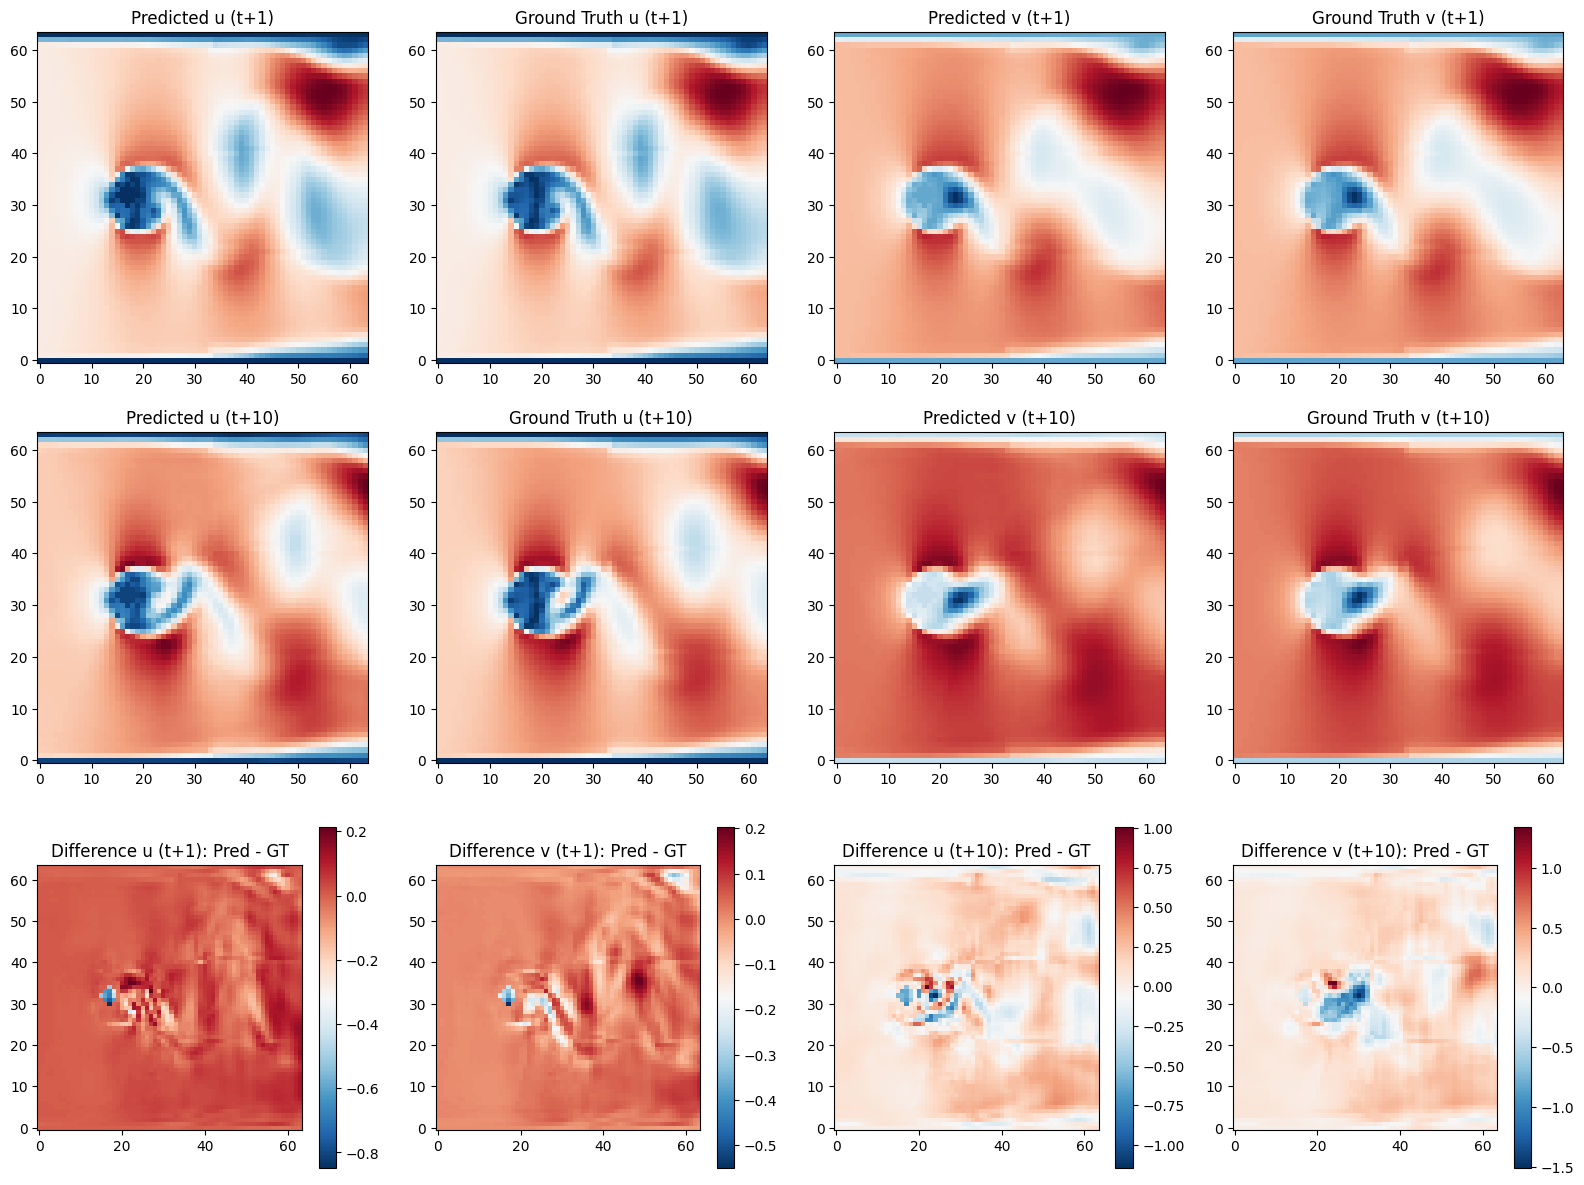

Visualization completed!


In [12]:
# Visualize predictions
model.eval()
with torch.no_grad():
    # Extract new format data
    sample_data = eval_dataset[0]
    sample_velocities, sample_case_params, sample_mask, sample_target = sample_data['new']
    
    # Add batch dimension and move to device
    sample_velocities = sample_velocities.unsqueeze(0).to(device)  # [1, H, W, 2]
    sample_case_params = sample_case_params.unsqueeze(0).to(device)  # [1, 8]
    sample_mask = sample_mask.unsqueeze(0).to(device)  # [1, H, W]
    sample_target = sample_target.unsqueeze(0).to(device)  # [1, K, H, W, 2]
    
    # Predict autoregressively
    current_velocities = sample_velocities.clone()  # Clone to avoid in-place modification
    predictions = []
    
    for k in range(rollout_steps):
        # Predict next step using improved model interface
        pred_next = model(
            current_velocities, 
            case_params=sample_case_params, 
            mask=sample_mask
        )  # [1, H, W, 2]
        
        predictions.append(pred_next[0].cpu().numpy())  # [H, W, 2]
        
        # Update current velocities for next autoregressive step
        # (case_params and mask remain constant across rollout)
        current_velocities = pred_next.clone()  # [1, H, W, 2]
    
    predictions = np.array(predictions)
    targets = sample_target[0].cpu().numpy()
    
    # Compute differences (Prediction - Ground Truth)
    diff_t1_u = predictions[0, :, :, 0] - targets[0, :, :, 0]
    diff_t1_v = predictions[0, :, :, 1] - targets[0, :, :, 1]
    last_idx = rollout_steps - 1
    diff_t3_u = predictions[last_idx, :, :, 0] - targets[last_idx, :, :, 0]
    diff_t3_v = predictions[last_idx, :, :, 1] - targets[last_idx, :, :, 1]
    
    # Plot: 3 rows x 4 columns (add difference row)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    # Row 0: First timestep (t+1)
    axes[0, 0].imshow(predictions[0, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[0, 0].set_title('Predicted u (t+1)')
    
    axes[0, 1].imshow(targets[0, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[0, 1].set_title('Ground Truth u (t+1)')
    
    axes[0, 2].imshow(predictions[0, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[0, 2].set_title('Predicted v (t+1)')
    
    axes[0, 3].imshow(targets[0, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[0, 3].set_title('Ground Truth v (t+1)')
    
    # Row 1: Last timestep (t+3)
    axes[1, 0].imshow(predictions[last_idx, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[1, 0].set_title(f'Predicted u (t+{rollout_steps})')
    
    axes[1, 1].imshow(targets[last_idx, :, :, 0], cmap='RdBu_r', origin='lower')
    axes[1, 1].set_title(f'Ground Truth u (t+{rollout_steps})')
    
    axes[1, 2].imshow(predictions[last_idx, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[1, 2].set_title(f'Predicted v (t+{rollout_steps})')
    
    axes[1, 3].imshow(targets[last_idx, :, :, 1], cmap='RdBu_r', origin='lower')
    axes[1, 3].set_title(f'Ground Truth v (t+{rollout_steps})')
    
    # Row 2: Differences (Prediction - Ground Truth)
    im1 = axes[2, 0].imshow(diff_t1_u, cmap='RdBu_r', origin='lower')
    axes[2, 0].set_title('Difference u (t+1): Pred - GT')
    plt.colorbar(im1, ax=axes[2, 0])
    
    im2 = axes[2, 1].imshow(diff_t1_v, cmap='RdBu_r', origin='lower')
    axes[2, 1].set_title('Difference v (t+1): Pred - GT')
    plt.colorbar(im2, ax=axes[2, 1])
    
    im3 = axes[2, 2].imshow(diff_t3_u, cmap='RdBu_r', origin='lower')
    axes[2, 2].set_title(f'Difference u (t+{rollout_steps}): Pred - GT')
    plt.colorbar(im3, ax=axes[2, 2])
    
    im4 = axes[2, 3].imshow(diff_t3_v, cmap='RdBu_r', origin='lower')
    axes[2, 3].set_title(f'Difference v (t+{rollout_steps}): Pred - GT')
    plt.colorbar(im4, ax=axes[2, 3])
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization completed!")
